In [73]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [74]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [75]:
X_train = np.reshape(X_train,(60000,28*28))
print (X_train.shape[0])
index_data = np.arange(X_train.shape[0])
np.random.shuffle(index_data)
index_train = index_data[:50000]
index_test = index_data[50000:]
x_train = X_train[index_train].T
Y_train = y_train[index_train]
x_test = X_train[index_test].T
Y_test = y_train[index_test]
print (x_train.shape)

60000
(784, 50000)


In [76]:
def normalize_MNIST_images(x):
    x = 2 * (x.astype(np.float64) - 0) / 255 - 1
    return x
x_train = normalize_MNIST_images(x_train)
x_test = normalize_MNIST_images(x_test)

In [77]:
def softmax(a):
    '''
    softmax activation function
    '''
    M = np.max(a, axis = 0)
    exp_a = np.exp(a - M)
    y = exp_a / np.sum(exp_a, axis = 0)
    return y
def softmaxp(a, e):
    out_softmax = softmax(a)
    delta = out_softmax * e - (out_softmax * e).sum(axis = 0) * out_softmax
    #print delta.shape
    return delta

In [78]:
def relu(a):
    return np.maximum(0, a)
def relup(a, e):
    return e * (a > 0)

In [79]:
def onehot2label(d):
    lbl = d.argmax(axis=0) 
    return lbl
def label2onehot(lbl):
    '''
    Convert sigle digit label to one-hot ecoding format
    '''
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(0, lbl.size)] = 1
    return d
dtrain = label2onehot(Y_train)
dtest = label2onehot(Y_test)
print (dtrain)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


### 1 hidden layer

In [80]:
def init_shallow(Ni, Nh, No):
    '''
    Initialize all the weights and bias
    '''
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2

Ni = x_train.shape[0]
Nh = 64
No = dtrain.shape[0]
print (x_train.shape)
netinit = init_shallow(Ni, Nh, No)
print (No)

(784, 50000)
10


In [81]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    
    return y

yinit = forwardprop_shallow(x_train, netinit)

In [82]:
def eval_loss(y, d):
    E = - np.sum(d * np.log(y) + (1 - d) * np.log(1-y), axis = 0) / 10
    total_loss = np.mean(E)
    return total_loss

print(eval_loss(yinit, dtrain), 'should be around .36')

0.3897906361402835 should be around .36


In [83]:
def eval_perfs(y, lbl):
    pred_y = onehot2label(y)
    return np.sum(pred_y != lbl) / float(pred_y.size)

In [84]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size 
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    ep = -d / y + (1 - d) / (1 - y)
    delta2 = softmaxp(a2, ep)
    delta1 = relup(a1, (W2.T.dot(delta2) + b2.T.dot(delta2)))
    W2 = W2 - gamma * delta2.dot(h1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis=1).reshape(10,1)
    b1 = b1 - gamma * delta1.sum(axis=1).reshape(64,1)
    return W1, b1, W2, b2

# print (update_shallow(x_train, dtrain, netinit, gamma=.05))

In [85]:
# print ("==="*7 + "Start Training" + "==="*7)

# print ("==="*7 + "Training Ends" + "==="*7)

loss: 0.3897906361402835
error: 0.86892


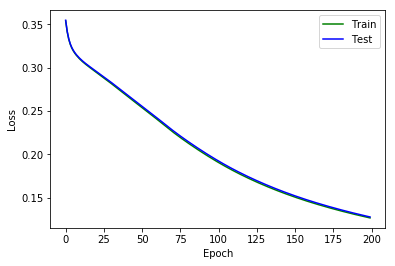

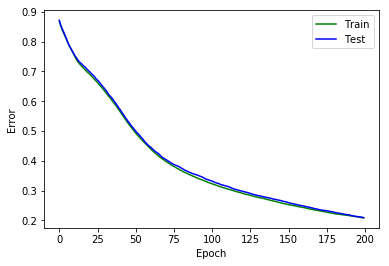

In [86]:
train_loss_list = []
train_error_list = []
test_loss_list = []
test_error_list = []
def backprop_shallow(x, d, net, T, gamma): 
    lbl = onehot2label(d)
    y = forwardprop_shallow(x, net)
    lbltest = onehot2label(dtest)
    y2 = forwardprop_shallow(x_test, net)
    
    loss1 = eval_loss(y, d)
    error1 = eval_perfs(y, lbl)
    loss2 = eval_loss(y2, dtest)
    error2 = eval_perfs(y2, lbltest)
    print ('loss:', loss1)
    print ('error:', error1)
    for t in range(0, T):
        net = update_shallow(x, d, net, gamma)
        y = forwardprop_shallow(x, net)
        yt = forwardprop_shallow(x_test, net)
        
        loss = eval_loss(y, d)
        train_loss_list.append(loss)
#         print ('loss:', loss)
        error = eval_perfs(y, lbl)
        train_error_list.append(error)
        
        losst = eval_loss(yt, dtest)
        test_loss_list.append(losst)
#         print ('loss:', loss)
        errort = eval_perfs(yt, lbltest)
        test_error_list.append(errort)
#         print('Epoch {0:3d}; Training Loss: {1:0.4f}; Training Error: {2:0.4f}'\
#               .format(t, loss,  error))
    return net
nettrain = backprop_shallow(x_train, dtrain, netinit, 200,0.01)

# test_loss_list = []
# test_error_list = []
# def backprop_shallow1(x, d, net, T, gamma): 
#     lbl = onehot2label(d)
#     y1 = forwardprop_shallow(x, net)
#     loss1 = eval_loss(y1, d)
#     error1 = eval_perfs(y1, lbl)
#     print ('loss:', loss1)
#     print ('error:', error1)
#     for t in range(0, T):
#         net = update_shallow(x, d, net, gamma)
#         y = forwardprop_shallow(x, net)
#         loss = eval_loss(y, d)
#         test_loss_list.append(loss)
# #         print ('loss:', loss)
#         error = eval_perfs(y, lbl)
#         test_error_list.append(error)
# #         print('Epoch {0:3d}; Training Loss: {1:0.4f}; Training Error: {2:0.4f}'\
# #               .format(t, loss,  error))
#     return net
# nettrain1 = backprop_shallow1(x_test, dtest, netinit, 500,0.01)

plt.figure()
plt.plot(train_loss_list, color='green')
plt.plot(test_loss_list, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper right')
plt.show()

plt.figure()
plt.plot(train_error_list, color='green')
plt.plot(test_error_list, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Train','Test'],loc='upper right')
plt.show()

In [87]:
# print (train_loss_list)

In [88]:
# print (test_loss_list)

### 2 hidden laiers

In [89]:
def init_shallow(Ni, Nh1, Nh2, No):
    '''
    Initialize all the weights and bias
    '''
    b1 = np.random.randn(Nh1, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh1, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(Nh2, 1) / np.sqrt((Nh1+1.)/2.)
    W2 = np.random.randn(Nh2, Nh1) / np.sqrt((Nh1+1.)/2.)
    b3 = np.random.randn(No, 1) / np.sqrt((Nh2+1.))
    W3 = np.random.randn(No, Nh2) / np.sqrt((Nh2+1.))
    return W1, b1, W2, b2, W3, b3

Ni = x_train.shape[0]
Nh1 = 64
Nh2 = 32
No = dtrain.shape[0]
print (x_train.shape)
netinit = init_shallow(Ni, Nh1, Nh2, No)
print (No)

(784, 50000)
10


In [90]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    W3 = net[4]
    b3 = net[5]
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    h2 = relu(a2)
    a3 = W3.dot(h2) + b3
    y = softmax(a3)
    
    return y

yinit = forwardprop_shallow(x_train, netinit)

In [91]:
def eval_loss(y, d):
    E = - np.sum(d * np.log(y) + (1 - d) * np.log(1-y), axis = 0) / 10
    total_loss = np.mean(E)
    return total_loss

print(eval_loss(yinit, dtrain), 'should be around .36')

0.33814272551118424 should be around .36


In [92]:
def eval_perfs(y, lbl):
    pred_y = onehot2label(y)
    return np.sum(pred_y != lbl) / float(pred_y.size)

In [93]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    W3 = net[4]
    b3 = net[5]
    Ni = W1.shape[1]
    Nh1 = W1.shape[0]
    Nh2 = W2.shape[0]
    No = W3.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size 
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    h2 = relu(a2)
    a3 = W3.dot(h2) + b3
    y = softmax(a3)
    ep = -d / y + (1 - d) / (1 - y)
    delta3 = softmaxp(a3, ep)
    delta2 = relup(a2, (W3.T.dot(delta3) + b3.T.dot(delta3)))
    delta1 = relup(a1, (W2.T.dot(delta2) + b2.T.dot(delta2)))
    W3 = W3 - gamma * delta3.dot(h2.T)
    W2 = W2 - gamma * delta2.dot(h1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b3 = b3 - gamma * delta3.sum(axis=1).reshape(10,1)
    b2 = b2 - gamma * delta2.sum(axis=1).reshape(32,1)
    b1 = b1 - gamma * delta1.sum(axis=1).reshape(64,1)
    return W1, b1, W2, b2, W3, b3

# print (update_shallow(x_train, dtrain, netinit, gamma=.05))

loss: 0.33814272551118424
error: 0.93274


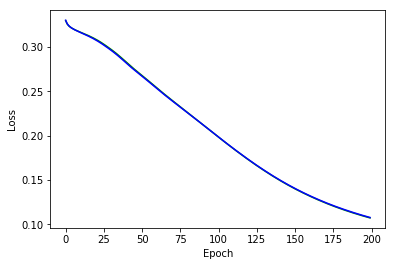

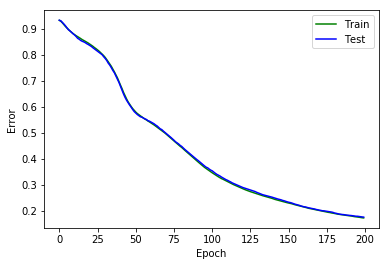

In [94]:
train_loss_list = []
train_error_list = []
test_loss_list = []
test_error_list = []
def backprop_shallow(x, d, net, T, gamma): 
    lbl = onehot2label(d)
    y = forwardprop_shallow(x, net)
    lbltest = onehot2label(dtest)
    y2 = forwardprop_shallow(x_test, net)
    
    loss1 = eval_loss(y, d)
    error1 = eval_perfs(y, lbl)
    loss2 = eval_loss(y2, dtest)
    error2 = eval_perfs(y2, lbltest)
    print ('loss:', loss1)
    print ('error:', error1)
    for t in range(0, T):
        net = update_shallow(x, d, net, gamma)
        y = forwardprop_shallow(x, net)
        yt = forwardprop_shallow(x_test, net)
        
        loss = eval_loss(y, d)
        train_loss_list.append(loss)
#         print ('loss:', loss)
        error = eval_perfs(y, lbl)
        train_error_list.append(error)
        
        losst = eval_loss(yt, dtest)
        test_loss_list.append(losst)
#         print ('loss:', loss)
        errort = eval_perfs(yt, lbltest)
        test_error_list.append(errort)
#         print('Epoch {0:3d}; Training Loss: {1:0.4f}; Training Error: {2:0.4f}'\
#               .format(t, loss,  error))
    return net
nettrain = backprop_shallow(x_train, dtrain, netinit, 200,0.01)

# train_loss_list = []
# train_error_list = []
# test_loss_list = []
# test_error_list = []
# def backprop_shallow(x, d, net, T, gamma): 
#     lbl = onehot2label(d)
#     y1 = forwardprop_shallow(x, net)
#     loss1 = eval_loss(y1, d)
#     error1 = eval_perfs(y1, lbl)
#     print ('loss:', loss1)
#     print ('error:', error1)
#     for t in range(0, T):
#         net = update_shallow(x, d, net, gamma)
#         y = forwardprop_shallow(x, net)
#         loss = eval_loss(y, d)
#         train_loss_list.append(loss)
# #         print ('loss:', loss)
#         error = eval_perfs(y, lbl)
#         train_error_list.append(error)
# #         print('Epoch {0:3d}; Training Loss: {1:0.4f}; Training Error: {2:0.4f}'\
# #               .format(t, loss,  error))
#     return net
# nettrain = backprop_shallow(x_train, dtrain, netinit, 500,0.01)

# test_loss_list = []
# test_error_list = []
# def backprop_shallow1(x, d, net, T, gamma): 
#     lbl = onehot2label(d)
#     y1 = forwardprop_shallow(x, net)
#     loss1 = eval_loss(y1, d)
#     error1 = eval_perfs(y1, lbl)
#     print ('loss:', loss1)
#     print ('error:', error1)
#     for t in range(0, T):
#         net = update_shallow(x, d, net, gamma)
#         y = forwardprop_shallow(x, net)
#         loss = eval_loss(y, d)
#         test_loss_list.append(loss)
# #         print ('loss:', loss)
#         error = eval_perfs(y, lbl)
#         test_error_list.append(error)
# #         print('Epoch {0:3d}; Training Loss: {1:0.4f}; Training Error: {2:0.4f}'\
# #               .format(t, loss,  error))
#     return net
# nettrain1 = backprop_shallow1(x_test, dtest, netinit, 500,0.01)

plt.figure
plt.plot(train_loss_list, color='green')
plt.plot(test_loss_list, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure
plt.plot(train_error_list, color='green')
plt.plot(test_error_list, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Train','Test'],loc='upper right')
plt.show()

In [95]:
# print ("==="*7 + "Start Training" + "==="*7)
# nettrain = backprop_shallow(x_train, dtrain, netinit, 100,0.1)
# print ("==="*7 + "Training Ends" + "==="*7)

In [96]:
a=[1,2]
b=a[:]
a=[]
print (b)

[1, 2]
